# Estimating a model with a known number of bumps

This section will show you how to estimate a single HsMM model with a given number of bump. We will use data generated for the demo on the github main page.

In [1]:
import hsmm_mvpy as hsmm
import numpy as np
import mne 

event_id = {'stimulus':1}
resp_id = {'response':5}

# Reading the events and the  data
eeg_dat = hsmm.utils.read_mne_EEG('../simulated/dataset_tutorial_raw.fif', event_id, resp_id, 100, verbose=False)

hsmm_dat, PCs, explained_var, means = hsmm.utils.transform_data(eeg_dat.data,'',
        apply_standard=False, single=True, n_comp=10, return_weights=True)

hsmm_dat = hsmm.utils.stack_data(hsmm_dat, single=True)

#Reading position of the elctrodes
raw = mne.io.read_raw_fif('../simulated/dataset_tutorial_raw.fif', preload=False)
positions = np.delete(mne.channels.layout._find_topomap_coords(raw.info, 'eeg'), 52, axis=0)#inferring electrode location

Processing participant ../simulated/dataset_tutorial_raw.fif
Reading 0 ... 104999  =      0.000 ...   174.819 secs...
Downsampling to 100 Hz
N trials without response event: 0
Applying reaction time trim to keep RTs between 0.001 and 5 seconds
30 trials were retained for participant ../simulated/dataset_tutorial_raw.fif
End sampling frequency is 100 Hz
Opening raw data file ../simulated/dataset_tutorial_raw.fif...
    Read a total of 4 projection items:
        PCA-v1 (1 x 102) active
        PCA-v2 (1 x 102) active
        PCA-v3 (1 x 102) active
        Average EEG reference (1 x 60) active
    Range : 0 ... 104999 =      0.000 ...   174.819 secs
Ready.


HsMM-MVpy uses classes to instantiate fit of HsMM models. Therefore before estimating a model one needs to declare an instance of the HsMM class by specifying the data, the starts and ends of the epochs, the sampling frequency of the data as well as several parmeters such as the bump width (in milliseconds) and how many CPU to use.

In [2]:
init = hsmm.models.hsmm(hsmm_dat.data.T[:,:,0], hsmm_dat.starts.data, 
                 hsmm_dat.ends.data, sf=eeg_dat.sfreq, bump_width=50, cpus=16)#Initialization of the model

Once the class has been initiated, the function ```fit_single()``` can be used to estimate one HsMM model with a specified number of bumps

Estimating all solutions for 4 bumps model with 0 random starting points
Estimating parameters for 4 bumps model
Parameters estimated for 4 bumps model


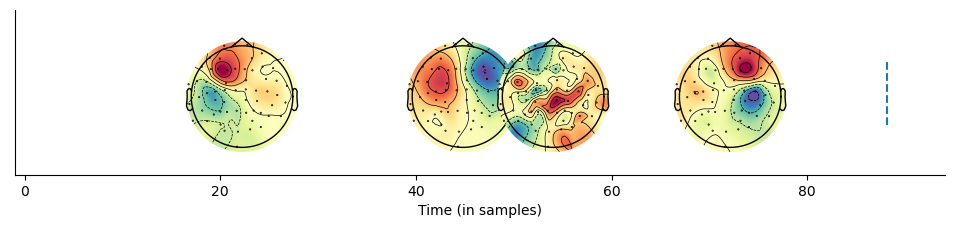

In [3]:
#Fitting
selected = init.fit_single(4)#function to fit an instance of a 4 bumps model

#Visualizing
electrodes_selected = hsmm.utils.reconstruct(selected.magnitudes, PCs, explained_var, means)#reconstructing electrode activity
bump_times_selected = init.bump_times(selected.eventprobs)#computing predicted bump times
mean_bump_times_selected = np.mean(bump_times_selected, axis=0)
hsmm.visu.plot_topo_timecourse(electrodes_selected, mean_bump_times_selected, positions, 
                               bump_size=init.bump_width_samples, magnify=5, figsize=(12,2),
                                time_step = 1,  times_to_display = np.mean(init.ends - init.starts))

 Now launching a single model without random starting point is not a good idea as most of the time the default starting values of the expectation maximization algorithm (that assumes bumps are evenly distributed) will end up in a local minima. This can be seen by the fact that all bumps are more or less evenly distributed and the 3rd bump doesn't look like a typical brain activity.
 
A better idea is to run a single model with several starting points as can be declared in the ```single_fit()``` function, hereby an example with 200 random starting points:

Estimating all solutions for 4 bumps model with 199 random starting points
Estimating parameters for 4 bumps model
Parameters estimated for 4 bumps model


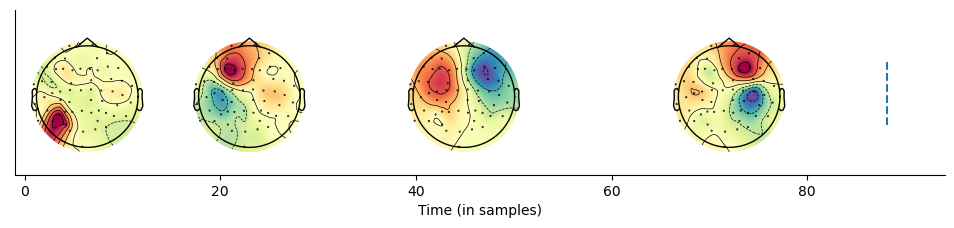

In [4]:
selected = init.fit_single(4, starting_points=200) #adding random starting points

electrodes_selected = hsmm.utils.reconstruct(selected.magnitudes, PCs, explained_var, means)
bump_times_selected = init.bump_times(selected.eventprobs)
mean_bump_times_selected = np.mean(bump_times_selected, axis=0)

hsmm.visu.plot_topo_timecourse(electrodes_selected, mean_bump_times_selected, positions, 
                               bump_size=init.bump_width_samples, magnify=5, figsize=(12,2),
                                time_step = 1,  times_to_display = np.mean(init.ends - init.starts))

Now this solution might not be enough for example with long reaction times and a low number of bumps. Therefore, an even better solution than random points is to estimate the maximal number of possible bumps. The idea is that genuine bumps will necessarily be found at the expected locations in the maximal number of bump model and because the backward estimation method iteratively removes the weakest bump (in terms of likelihood), only the 'strongest' bumps remains even if there location would have been hard to find with a single fit and default starting values.

In [5]:
bests = init.backward_estimation()
bests

Estimating all solutions for maximal number of bumps (5) with 0 random starting points
Estimating all solutions for 5 bumps model with 0 random starting points
Estimating parameters for 5 bumps model
Parameters estimated for 5 bumps model


<xarray.Dataset>
Dimensions:      (n_bumps: 5, stage: 6, params: 2, component: 10, bump: 5,
                  samples: 196, trial: 30)
Coordinates:
  * n_bumps      (n_bumps) int64 5 4 3 2 1
Dimensions without coordinates: stage, params, component, bump, samples, trial
Data variables:
    likelihoods  (n_bumps) float64 986.1 1.023e+03 840.5 534.8 192.9
    parameters   (n_bumps, stage, params) float64 2.0 0.5969 2.0 ... nan nan nan
    magnitudes   (n_bumps, component, bump) float64 -0.6797 4.115 ... nan nan
    eventprobs   (n_bumps, samples, trial, bump) float64 0.0 0.0 0.0 ... nan nan

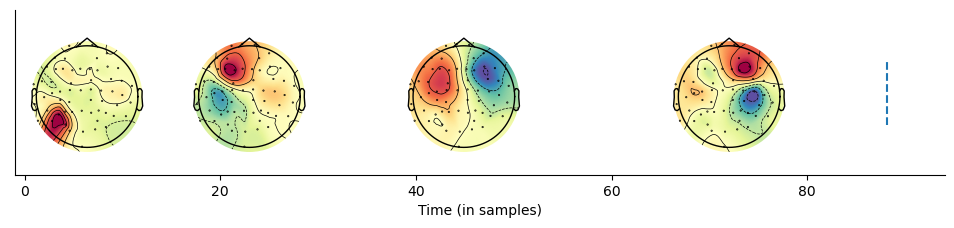

In [6]:
selected = bests.sel(n_bumps=4)
bump_times_selected = init.bump_times(selected.eventprobs.dropna('bump'))
mean_bump_times_selected = np.mean(bump_times_selected, axis=0)
electrodes_selected = hsmm.utils.reconstruct(selected.magnitudes,PCs, explained_var, means)

hsmm.visu.plot_topo_timecourse(electrodes_selected, mean_bump_times_selected, positions, 
                               bump_size=init.bump_width_samples, magnify=5, figsize=(12,2),
                                time_step = 1,  times_to_display = np.mean(init.ends - init.starts))

Note that we can also combine both methods and estimate the bumps iteratively while also adding random starting points. However, if ```max_starting_point``` is specified, only the maximum model is estimated with random starting points as if everything was correctly estimated in the maximum model, any random starting point on subsequent model should yield a lower likelihood.

In [7]:
bests = init.backward_estimation(max_starting_points=200)
bests

Estimating all solutions for maximal number of bumps (5) with 199 random starting points
Estimating all solutions for 5 bumps model with 199 random starting points
Estimating parameters for 5 bumps model


/home/gweindel/anaconda3/envs/seqdec/lib/python3.10/site-packages/hsmm_mvpy/models.py:449: RuntimeWarning: invalid value encountered in true_divide
  d = d/np.sum(d)


Parameters estimated for 5 bumps model


<xarray.Dataset>
Dimensions:      (n_bumps: 5, stage: 6, params: 2, component: 10, bump: 5,
                  samples: 196, trial: 30)
Coordinates:
  * n_bumps      (n_bumps) int64 5 4 3 2 1
Dimensions without coordinates: stage, params, component, bump, samples, trial
Data variables:
    likelihoods  (n_bumps) float64 1.006e+03 1.023e+03 840.5 534.8 192.9
    parameters   (n_bumps, stage, params) float64 2.0 0.5987 2.0 ... nan nan nan
    magnitudes   (n_bumps, component, bump) float64 -0.6801 4.118 ... nan nan
    eventprobs   (n_bumps, samples, trial, bump) float64 0.0 0.0 0.0 ... nan nan